# Land Cover Classification
### Objective: Classify an image using the Raster API and SciKit Learn

This image classification uses the Scenes API to filter the Hyperspectral Collection imagery over Russia. The tutorial uses GDAL to rasterize training data and scikit-learn to train and run a Random Forest Classification. We begin by importing the necessary libraries.

In [1]:
import descarteslabs as dl
from osgeo import gdal
import os
import numpy as np
import scipy
from matplotlib import colors
from sklearn.ensemble import RandomForestClassifier 
from skimage.segmentation import quickshift, felzenszwalb
from skimage import exposure
from sklearn import metrics
import matplotlib.pyplot as plt
# %matplotlib inline

The GeoJSON feature defined below is a rectangle containing a lake, forest, and plantations. This feature will be used to search for imagery and as the extent of our analysis. 

In [2]:
region = {"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[59.74743751447837,54.450086973406485],[59.79886913062678,54.450086973406485],[59.79886913062678,54.504898909776074],[59.74743751447837,54.504898909776074],[59.74743751447837,54.450086973406485]]]}}

## Get data from Raster API 

The `metadata` and `raster` APIs allow you to query our catalog of imagery. Here, we specify the geometry, product, and date parameters to reflect the available hyperspectral imagery. The `search` method a list containing metdata of all matching scenes. We use list comprehension to extract their ids to access their data through the `raster` API.

In [3]:
scenes = dl.metadata.search(region['geometry'],
                    product="ed08ce8609216626e16e25cbd89f7757f48bee3d:hyperion:dev",
                    start_datetime="2004-07-31",
                    end_datetime="2004-12-31",
                    limit=10
                   )

ids = [f['id'] for f in scenes['features']]
print(len(ids))

10


In [4]:
arr, meta = dl.raster.ndarray(
    ids,
    data_type='Int16',
    resolution=30,
    cutline=region['geometry']
    )

composite = arr 
print(composite.shape)

(208, 119, 242)


The output is a tuple, where the second item contains `metadata` information we can extract to rasterize our training data. 

In [78]:
geo_transform = meta['geoTransform']
proj= meta['coordinateSystem']['wkt']
rows, cols, bands = composite.shape

## Write helper functions to rasterize vector 
We need a library of functions to rasterize our training data.

In [35]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    print
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

## Segmentation

In [57]:
rows, cols, n_bands = composite.shape
band_segmentation = []
for i in range(n_bands):
    band_segmentation.append(felzenszwalb(composite[:, :, i], scale=85, sigma=0.25, min_size=9))

In [62]:
const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate(band_segmentation[1:]):
    segmentation += s * np.prod(const[:i+1])

_, labels = np.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(composite.shape[:2])

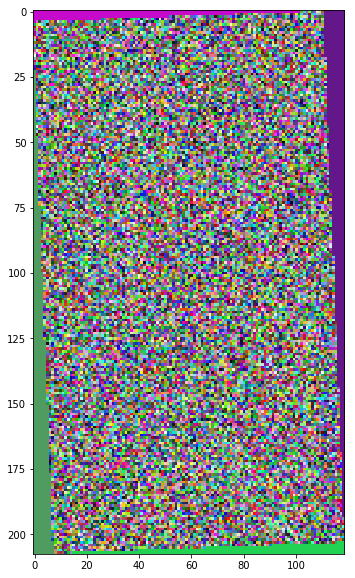

In [19]:
cmap = colors.ListedColormap(np.random.rand(len(np.unique(segments_felz)), 3))
plt.figure(figsize=[10,10])
plt.imshow(segments_felz, interpolation='none', cmap=cmap)

In [20]:
segments = segments_felz
segment_ids = np.unique(segments)
print("Felzenszwalb segmentation. %i segments." % len(segment_ids))

Felzenszwalb segmentation. 22620 segments.


## Load training data

The data used to train the classifier are individual shapefiles being read in from a file. 

In [36]:
train_data_path = "hyperion_training_data/train"
test_data_path = "hyperion_training_data/test"

In [65]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
class_labels = [f.split('.')[0] for f in files]
print("There are {} classes:".format(len(class_labels)))
for c in class_labels:
    print(c)
 
shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = composite[is_train]

There are 3 classes:
water_train
field_train
forest_train


In [71]:
ground_truth = vectors_to_raster(shapefiles, 208, 119, geo_transform, proj)
classes = np.unique(labeled_pixels)[1:]  # 0 doesn't count
len(classes)

3

In [73]:
segments_per_klass  = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

Training segments for class 1: 3
Training segments for class 2: 7
Training segments for class 3: 7


## Classification

Train the classifier and run the land cover classification.

In [74]:
train_img = np.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    klass_label = threshold + klass
    for segment_id in segments_per_klass[klass]:
        train_img[train_img == segment_id] = klass_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

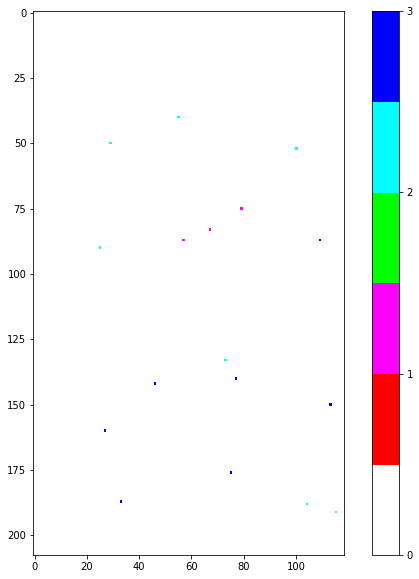

In [75]:
plt.figure(figsize=[10,10])
cm = np.array([[ 1,  1,  1 ], [ 1,0,0], [ 1,0,1], [ 0,1,0], [ 0,1,1], [ 0,0,1]])
cmap = colors.ListedColormap(cm)
plt.imshow(train_img, cmap=cmap)
plt.colorbar(ticks=[0,1,2,3,4,5])

In [76]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features

In [77]:
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU 
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = composite[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        # Keep a reference to the segment label
        objects_ids.append(segment_label)  

    print("Created %i objects" % len(objects))

Created 22620 objects


In [79]:
training_labels = []
training_objects = []
for klass in classes:
    class_train_objects = [v for i, v in enumerate(objects) if objects_ids[i] in segments_per_klass[klass]]
    training_labels += [klass] * len(class_train_objects)
    print("Training samples for class %i: %i" % (klass, len(class_train_objects)))
    training_objects += class_train_objects

Training samples for class 1: 3
Training samples for class 2: 7
Training samples for class 3: 7


In [80]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_objects, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [81]:
predicted  = classifier.predict(objects)
clf = np.copy(segments)
for segment_id, klass in zip(objects_ids, predicted):
    clf[clf==segment_id] = klass

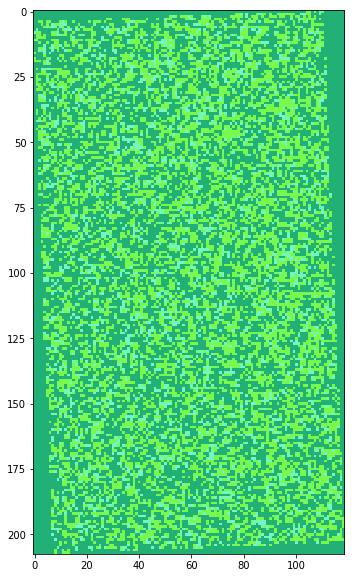

In [82]:
plt.figure(figsize=[10,10])
plt.imshow(clf, interpolation='none', cmap=colors.ListedColormap(np.random.rand(len(class_labels), 3)))